In [123]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('Project1_Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
#!kaggle competitions download -c da218o-class-competition-predict-missing-data



Project1_Data/coordinates.csv
Project1_Data/Node_501.csv
Project1_Data/Node_502.csv
Project1_Data/Node_505.csv
Project1_Data/Node_507.csv
Project1_Data/Node_508.csv
Project1_Data/Node_locations.xlsx
Project1_Data/sample_submission.csv
Project1_Data/submission_file.csv


In [124]:
pd1 = pd.read_csv('Project1_Data/Node_501.csv')
pd1['lat'] = -37.8148084
pd1['lng'] = 144.980999
pd1['node'] = 1

pd2 = pd.read_csv('Project1_Data/Node_502.csv')
pd2['lat'] = -37.8146097
pd2['lng'] = 144.9790177
pd2['node'] = 2

pd4 = pd.read_csv('Project1_Data/Node_505.csv')
pd4['lat'] = -37.813073
pd4['lng'] = 144.9804061
pd4['node'] = 4

pd5 = pd.read_csv('Project1_Data/Node_507.csv')
pd5['lat'] = -37.8149218
pd5['lng'] = 144.9822582
pd5['node'] = 5

pd3 = pd.read_csv('Project1_Data/Node_508.csv')
pd3['lat'] = -37.8134078
pd3['lng'] = 144.9794923
pd3['node'] = 3



In [125]:
# center coordinate of all 5 sensors
lat0 = -37.8141641 #average of all 5 latitutes
lng0 = 144.9804347 #average of all 5 longitutude

In [126]:
spd = pd.concat([pd1, pd2,pd3,pd4,pd5], axis=0)
# spd = pd.concat([pd3], axis=0)

## Data preprocessing

In [127]:
spd['ts'] = spd.timestamp.apply(lambda x: pd.to_datetime(x.replace('/0014','/2014').replace('/0015','/2015'),format='%d/%m/%Y %H:%M'))
spd['ts_value'] = spd.ts.apply(lambda x: x.value/10**9/60)
spd['ts_10'] = spd.ts_value.apply(lambda x: math.floor(x/10))
spd['inde'] = (spd['node']*1e7 + spd['ts_10']).astype(int)
spd = spd.set_index('inde')

spd.shape

(6583, 10)

In [128]:
spd.head()

,ID,timestamp,temperature,humidity,lat,lng,node,ts,ts_value,ts_10
inde,,,,,,,,,,
12363472,1,09/12/0014 00:03,25.16,36.47,-37.814808,144.980999,1,2014-12-09 00:03:00,23634723.0,2363472
12363473,2,09/12/0014 00:13,24.83,35.52,-37.814808,144.980999,1,2014-12-09 00:13:00,23634733.0,2363473
12363474,3,09/12/0014 00:23,24.83,35.68,-37.814808,144.980999,1,2014-12-09 00:23:00,23634743.0,2363474
12363475,4,09/12/0014 00:33,24.83,35.84,-37.814808,144.980999,1,2014-12-09 00:33:00,23634753.0,2363475
12363476,5,09/12/0014 00:44,24.83,35.99,-37.814808,144.980999,1,2014-12-09 00:44:00,23634764.0,2363476


In [129]:
spd.describe()

,ID,temperature,humidity,lat,lng,node,ts_value,ts_10
count,6583.000000,6345.000000,6321.000000,6583.000000,6583.000000,6583.000000,6.583000e+03,6.583000e+03
mean,3292.000000,19.354319,47.591877,-37.814171,144.980477,3.016102,2.365330e+07,2.365329e+06
std,1900.492743,4.600579,13.342490,0.000773,0.001141,1.434284,1.312214e+04,1.312212e+03
min,1.000000,9.670000,-24.700000,-37.814922,144.979018,1.000000,2.363472e+07,2.363472e+06
25%,1646.500000,16.120000,37.100000,-37.814808,144.979492,2.000000,2.364616e+07,2.364616e+06
50%,3292.000000,19.670000,48.610000,-37.814610,144.980406,3.000000,2.365171e+07,2.365171e+06
75%,4937.500000,22.580000,57.917000,-37.813408,144.980999,4.000000,2.365524e+07,2.365524e+06
max,6583.000000,36.770000,76.990000,-37.813073,144.982258,5.000000,2.367975e+07,2.367975e+06


In [130]:
data = {'t': [-100,-100,-100,-100,-100,-100],
        'tr': [-100,-100,-100,-100,-100,-100],
        'h': [-100,-100,-100,-100,-100,-100],
        'hr': [-100,-100,-100,-100,-100,-100]}  
th = pd.DataFrame(data)

for i, row in spd.iterrows():
    if(th['t'][row['node']]!=-100):
        spd.at[i,'tp'] = th['t'][row['node']]
        spd.at[i,'tpr'] = th['tr'][row['node']]
    else:
        spd.at[i,'tp'] = row['temperature']
        spd.at[i,'tpr'] = row['ts_value']-1
    if(not math.isnan(row['temperature'])):
        th.at[row['node'],'t'] = row['temperature']
        th.at[row['node'],'tr'] = row['ts_value']
    if(th['h'][row['node']]!=-100):
        spd.at[i,'hp'] = th['h'][row['node']]
        spd.at[i,'hpr'] = th['hr'][row['node']]
    else:
        spd.at[i,'hp'] = row['humidity']
        spd.at[i,'hpr'] = row['ts_value']-1
    if(not math.isnan(row['humidity'])):
        th.at[row['node'],'h'] = row['humidity']
        th.at[row['node'],'hr'] = row['ts_value']


th = pd.DataFrame(data)
        
for i in reversed(spd.index):
    row = spd.loc[i]
    if(th['t'][row['node']]!=-100):
        spd.at[i,'tn'] = th['t'][row['node']]
        spd.at[i,'tnr'] = th['tr'][row['node']]
    else:
        spd.at[i,'tn'] = row['temperature']
        spd.at[i,'tnr'] = row['ts_value']+1
    if(not math.isnan(row['temperature'])):
        th.at[row['node'],'t'] = row['temperature']
        th.at[row['node'],'tr'] = row['ts_value']
    if(th['h'][row['node']]!=-100):
        spd.at[i,'hn'] = th['h'][row['node']]
        spd.at[i,'hnr'] = th['hr'][row['node']]
    else:
        spd.at[i,'hn'] = row['humidity']
        spd.at[i,'hnr'] = row['ts_value']-1
    if(not math.isnan(row['humidity'])):
        th.at[row['node'],'h'] = row['humidity']
        th.at[row['node'],'hr'] = row['ts_value']
        

In [131]:
spd.describe()

,ID,temperature,humidity,lat,lng,node,ts_value,ts_10,tp,tpr,hp,hpr,tn,tnr,hn,hnr
count,6583.000000,6345.000000,6321.000000,6583.000000,6583.000000,6583.000000,6.583000e+03,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03
mean,3292.000000,19.354319,47.591877,-37.814171,144.980477,3.016102,2.365330e+07,2.365329e+06,19.357265,2.365326e+07,47.567569,2.365326e+07,19.350204,2.365334e+07,47.615308,2.365333e+07
std,1900.492743,4.600579,13.342490,0.000773,0.001141,1.434284,1.312214e+04,1.312212e+03,4.590284,1.311274e+04,13.301033,1.311186e+04,4.592586,1.313547e+04,13.298862,1.313233e+04
min,1.000000,9.670000,-24.700000,-37.814922,144.979018,1.000000,2.363472e+07,2.363472e+06,9.670000,2.363472e+07,-24.700000,2.363472e+07,9.670000,2.363473e+07,-24.700000,2.363473e+07
25%,1646.500000,16.120000,37.100000,-37.814808,144.979492,2.000000,2.364616e+07,2.364616e+06,16.120000,2.364615e+07,37.100000,2.364615e+07,16.120000,2.364617e+07,37.100000,2.364617e+07
50%,3292.000000,19.670000,48.610000,-37.814610,144.980406,3.000000,2.365171e+07,2.365171e+06,19.670000,2.365170e+07,48.457000,2.365170e+07,19.670000,2.365172e+07,48.610000,2.365172e+07
75%,4937.500000,22.580000,57.917000,-37.813408,144.980999,4.000000,2.365524e+07,2.365524e+06,22.580000,2.365523e+07,57.910000,2.365523e+07,22.580000,2.365525e+07,57.913500,2.365525e+07
max,6583.000000,36.770000,76.990000,-37.813073,144.982258,5.000000,2.367975e+07,2.367975e+06,36.770000,2.367974e+07,76.990000,2.367974e+07,36.770000,2.367975e+07,76.990000,2.367975e+07


In [132]:
spd['tp'] = spd['tp'].fillna(spd['tn'])
spd['tpr'] = spd['tpr'].fillna(spd['ts_value']-1)
spd['tn'] = spd['tn'].fillna(spd['tp'])
spd['tnr'] = spd['tnr'].fillna(spd['ts_value']+1)

spd['hp'] = spd['hp'].fillna(spd['hn'])
spd['hpr'] = spd['hpr'].fillna(spd['ts_value']-1)
spd['hn'] = spd['hn'].fillna(spd['hp'])
spd['hnr'] = spd['hnr'].fillna(spd['ts_value']+1)


In [133]:
spd['tw'] = spd.apply(lambda r:
                      (r['tp']*(r['tnr']-r['ts_value']) + r['tn']*(-r['tpr']+r['ts_value'])) / (r['tnr']-r['tpr'])
                     ,axis = 1)
spd['hw'] = spd.apply(lambda r:
                      (r['hp']*(r['hnr']-r['ts_value']) + r['hn']*(-r['hpr']+r['ts_value'])) / (r['hnr']-r['hpr'])
                     ,axis = 1)

In [134]:
spd.describe()

,ID,temperature,humidity,lat,lng,node,ts_value,ts_10,tp,tpr,hp,hpr,tn,tnr,hn,hnr,tw,hw
count,6583.000000,6345.000000,6321.000000,6583.000000,6583.000000,6583.000000,6.583000e+03,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6.583000e+03,6583.000000,6583.000000
mean,3292.000000,19.354319,47.591877,-37.814171,144.980477,3.016102,2.365330e+07,2.365329e+06,19.357265,2.365326e+07,47.567569,2.365326e+07,19.350204,2.365334e+07,47.615308,2.365333e+07,19.352928,47.593733
std,1900.492743,4.600579,13.342490,0.000773,0.001141,1.434284,1.312214e+04,1.312212e+03,4.590284,1.311274e+04,13.301033,1.311186e+04,4.592586,1.313547e+04,13.298862,1.313233e+04,4.568489,13.210952
min,1.000000,9.670000,-24.700000,-37.814922,144.979018,1.000000,2.363472e+07,2.363472e+06,9.670000,2.363472e+07,-24.700000,2.363472e+07,9.670000,2.363473e+07,-24.700000,2.363473e+07,9.674000,-24.700000
25%,1646.500000,16.120000,37.100000,-37.814808,144.979492,2.000000,2.364616e+07,2.364616e+06,16.120000,2.364615e+07,37.100000,2.364615e+07,16.120000,2.364617e+07,37.100000,2.364617e+07,16.120000,37.149286
50%,3292.000000,19.670000,48.610000,-37.814610,144.980406,3.000000,2.365171e+07,2.365171e+06,19.670000,2.365170e+07,48.457000,2.365170e+07,19.670000,2.365172e+07,48.610000,2.365172e+07,19.515000,48.567619
75%,4937.500000,22.580000,57.917000,-37.813408,144.980999,4.000000,2.365524e+07,2.365524e+06,22.580000,2.365523e+07,57.910000,2.365523e+07,22.580000,2.365525e+07,57.913500,2.365525e+07,22.732381,57.893905
max,6583.000000,36.770000,76.990000,-37.813073,144.982258,5.000000,2.367975e+07,2.367975e+06,36.770000,2.367974e+07,76.990000,2.367974e+07,36.770000,2.367975e+07,76.990000,2.367975e+07,36.617619,76.613810


In [140]:
a = 0
for i in range(1,5):
    for j, row in spd.iterrows():
        node = (row['node']+i)%5 + 1
        inde = int(node*1e7+ row['ts_10'])
        try:
            node_row = spd.iloc[spd.index.get_indexer([inde],method='nearest')]
            if(not math.isnan(node_row['temperature'])):
                spd.at[j,'node'+str(i)+'t'] = node_row['temperature']
            else:
                spd.at[j,'node'+str(i)+'t'] = node_row['tw']

            if(not math.isnan(node_row['humidity'])):
                spd.at[j,'node'+str(i)+'h'] = node_row['humidity']
            else:
                spd.at[j,'node'+str(i)+'h'] = node_row['hw']
        except KeyError:
            print(inde)
            a = a+1
print ("error count ", a)

error count  0


In [139]:
# spd.iloc[spd.index.get_indexer([42367484],method='nearest')]

,ID,timestamp,temperature,humidity,lat,lng,node,ts,ts_value,ts_10,...,tw,hw,node1t,node1h,node2t,node2h,node3t,node3h,node4t,node4h
inde,,,,,,,,,,,,,,,,,,,,,
42367485,3834,05/01/0015 20:50,19.03,61.69,-37.813073,144.980406,4,2015-01-05 20:50:00,23674850.0,2367485,...,19.040476,60.12381,18.06,62.64,19.35,57.28,18.38,51.13,19.03,61.69


In [141]:
spd.head()

,ID,timestamp,temperature,humidity,lat,lng,node,ts,ts_value,ts_10,...,tw,hw,node1t,node1h,node2t,node2h,node3t,node3h,node4t,node4h
inde,,,,,,,,,,,,,,,,,,,,,
12363472,1,09/12/0014 00:03,25.16,36.47,-37.814808,144.980999,1,2014-12-09 00:03:00,23634723.0,2363472,...,25.130000,36.383636,23.54,36.310,23.87,36.15000,23.22,36.15000,25.16,36.47
12363473,2,09/12/0014 00:13,24.83,35.52,-37.814808,144.980999,1,2014-12-09 00:13:00,23634733.0,2363473,...,24.995000,36.075000,23.22,36.150,23.54,36.62000,22.90,36.31000,24.83,35.52
12363474,3,09/12/0014 00:23,24.83,35.68,-37.814808,144.980999,1,2014-12-09 00:23:00,23634743.0,2363474,...,24.830000,35.680000,23.54,35.840,23.54,36.15000,22.58,35.99000,24.83,35.68
12363475,4,09/12/0014 00:33,24.83,35.84,-37.814808,144.980999,1,2014-12-09 00:33:00,23634753.0,2363475,...,24.830000,35.827619,23.54,35.915,23.54,36.23381,22.90,36.07381,24.83,35.84
12363476,5,09/12/0014 00:44,24.83,35.99,-37.814808,144.980999,1,2014-12-09 00:44:00,23634764.0,2363476,...,24.662381,36.002381,23.22,35.990,23.54,36.31000,22.90,36.15000,24.83,35.99


In [142]:
spd.describe()

,ID,temperature,humidity,lat,lng,node,ts_value,ts_10,tp,tpr,...,tw,hw,node1t,node1h,node2t,node2h,node3t,node3h,node4t,node4h
count,6583.000000,6345.000000,6321.000000,6583.000000,6583.000000,6583.000000,6.583000e+03,6.583000e+03,6583.000000,6.583000e+03,...,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000,6583.000000
mean,3292.000000,19.354319,47.591877,-37.814171,144.980477,3.016102,2.365330e+07,2.365329e+06,19.357265,2.365326e+07,...,19.352928,47.593733,19.330783,47.435310,19.348212,47.524248,19.341881,47.529403,19.352168,47.591642
std,1900.492743,4.600579,13.342490,0.000773,0.001141,1.434284,1.312214e+04,1.312212e+03,4.590284,1.311274e+04,...,4.568489,13.210952,4.577040,13.321855,4.557636,13.189000,4.552716,13.166868,4.589761,13.295476
min,1.000000,9.670000,-24.700000,-37.814922,144.979018,1.000000,2.363472e+07,2.363472e+06,9.670000,2.363472e+07,...,9.674000,-24.700000,9.670000,-24.700000,9.670000,-24.700000,9.670000,-24.700000,9.670000,-24.700000
25%,1646.500000,16.120000,37.100000,-37.814808,144.979492,2.000000,2.364616e+07,2.364616e+06,16.120000,2.364615e+07,...,16.120000,37.149286,16.120000,37.100000,16.120000,37.100000,16.120000,37.100000,16.120000,37.100000
50%,3292.000000,19.670000,48.610000,-37.814610,144.980406,3.000000,2.365171e+07,2.365171e+06,19.670000,2.365170e+07,...,19.515000,48.567619,19.670000,48.290000,19.670000,48.450000,19.670000,48.290000,19.670000,48.610000
75%,4937.500000,22.580000,57.917000,-37.813408,144.980999,4.000000,2.365524e+07,2.365524e+06,22.580000,2.365523e+07,...,22.732381,57.893905,22.580000,57.757000,22.580000,57.910000,22.580000,57.910000,22.580000,57.910000
max,6583.000000,36.770000,76.990000,-37.813073,144.982258,5.000000,2.367975e+07,2.367975e+06,36.770000,2.367974e+07,...,36.617619,76.613810,36.770000,76.990000,36.770000,76.990000,36.770000,76.830000,36.770000,76.990000


In [207]:
spd['hps'] = spd['hp']-spd['hw']
spd['hns'] = spd['hn']-spd['hw']
spd['node1hs'] = spd['node1h']-spd['hw']
spd['node2hs'] = spd['node2h']-spd['hw']
spd['node3hs'] = spd['node3h']-spd['hw']
spd['node4hs'] = spd['node4h']-spd['hw']

spd['tps'] = spd['tp']-spd['tw']
spd['tns'] = spd['tn']-spd['tw']
spd['node1ts'] = spd['node1t']-spd['tw']
spd['node2ts'] = spd['node2t']-spd['tw']
spd['node3ts'] = spd['node3t']-spd['tw']
spd['node4ts'] = spd['node4t']-spd['tw']


In [208]:
tnan = (spd['temperature'].notna())
hnan = (spd['humidity'].notna())
#tnan.head()
#hnan.head()
spd_train = spd[tnan & hnan]
spd_t = spd[ (tnan)==False]
spd_h = spd[ (hnan)==False]

In [209]:
print(spd_train.shape)
spd_train.head()

(6083, 40)


,ID,timestamp,temperature,humidity,lat,lng,node,ts,ts_value,ts_10,...,node1hs,node2hs,node3hs,node4hs,tps,tns,node1ts,node2ts,node3ts,node4ts
inde,,,,,,,,,,,,,,,,,,,,,
12363472,1,09/12/0014 00:03,25.16,36.47,-37.814808,144.980999,1,2014-12-09 00:03:00,23634723.0,2363472,...,-0.073636,-0.233636,-0.233636,8.636364e-02,0.030000,-0.300000,-1.590000,-1.260000,-1.910000,0.030000
12363473,2,09/12/0014 00:13,24.83,35.52,-37.814808,144.980999,1,2014-12-09 00:13:00,23634733.0,2363473,...,0.075000,0.545000,0.235000,-5.550000e-01,0.165000,-0.165000,-1.775000,-1.455000,-2.095000,-0.165000
12363474,3,09/12/0014 00:23,24.83,35.68,-37.814808,144.980999,1,2014-12-09 00:23:00,23634743.0,2363474,...,0.160000,0.470000,0.310000,-7.105427e-15,0.000000,0.000000,-1.290000,-1.290000,-2.250000,0.000000
12363475,4,09/12/0014 00:33,24.83,35.84,-37.814808,144.980999,1,2014-12-09 00:33:00,23634753.0,2363475,...,0.087381,0.406190,0.246190,1.238095e-02,0.000000,0.000000,-1.290000,-1.290000,-1.930000,0.000000
12363476,5,09/12/0014 00:44,24.83,35.99,-37.814808,144.980999,1,2014-12-09 00:44:00,23634764.0,2363476,...,-0.012381,0.307619,0.147619,-1.238095e-02,0.167619,-0.152381,-1.442381,-1.122381,-1.762381,0.167619


In [183]:
print(spd_t.shape)
print(spd_h.shape)


(238, 28)
(262, 28)


### Temperature EDA

In [ ]:
sns.boxplot(data=spd_train,x='date',y='temperature')
plt.show()

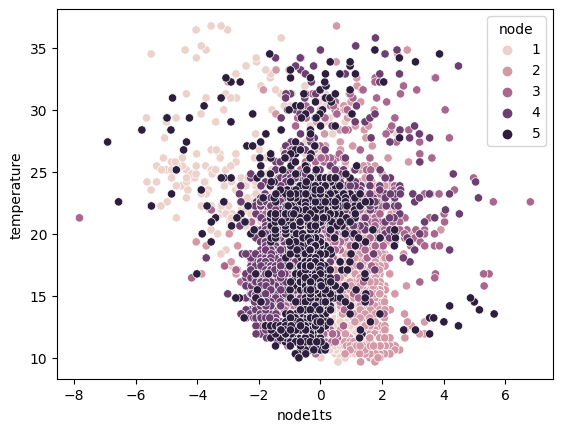

In [224]:
sns.scatterplot(data=spd_train,x='node1ts',y='temperature', hue='node')
plt.show()

In [ ]:
sns.scatterplot(data=spd_train,x='sin_minute',y='temperature', hue='ID')
plt.show()

### Humidity EDA

In [ ]:
sns.scatterplot(data=spd_train,x='mins',y='humidity', hue='ID')
plt.show()

In [ ]:
sns.scatterplot(data=spd_train,x='sin_minute',y='humidity', hue='ID')
plt.show()

In [ ]:
sns.scatterplot(data=spd_train,x='date',y='humidity', hue='ID')
plt.show()

In [ ]:
sns.boxplot(data=spd_train,x='date',y='humidity')
plt.show()

In [ ]:
spd_train.describe()

In [205]:
spd_train[['tp','tn','tw','node1t','node2t','node3t','node4t']].corr()

,tp,tn,tw,node1t,node2t,node3t,node4t
tp,1.000000,0.969781,0.989358,0.948354,0.948935,0.957544,0.984509
tn,0.969781,1.000000,0.989489,0.949412,0.948538,0.957595,0.984441
tw,0.989358,0.989489,1.000000,0.959080,0.959173,0.967840,0.994890
node1t,0.948354,0.949412,0.959080,1.000000,0.967018,0.958220,0.958337
node2t,0.948935,0.948538,0.959173,0.967018,1.000000,0.968018,0.958369
node3t,0.957544,0.957595,0.967840,0.958220,0.968018,1.000000,0.967734
node4t,0.984509,0.984441,0.994890,0.958337,0.958369,0.967734,1.000000


In [206]:
spd_train[['hp','hn','hw','node1h','node2h','node3h','node4h']].corr()

,hp,hn,hw,node1h,node2h,node3h,node4h
hp,1.000000,0.965365,0.989060,0.908899,0.910828,0.890741,0.984216
hn,0.965365,1.000000,0.989413,0.909740,0.911447,0.891671,0.984754
hw,0.989060,0.989413,1.000000,0.919255,0.921192,0.901045,0.995209
node1h,0.908899,0.909740,0.919255,1.000000,0.897080,0.920919,0.917932
node2h,0.910828,0.911447,0.921192,0.897080,1.000000,0.900242,0.919993
node3h,0.890741,0.891671,0.901045,0.920919,0.900242,1.000000,0.900517
node4h,0.984216,0.984754,0.995209,0.917932,0.919993,0.900517,1.000000


## Linear Regression
Trying out different ML approches (non-probabilistic)

In [149]:
from sklearn.linear_model import LinearRegression



In [237]:
model = LinearRegression()
X = spd_train[['node','tp','tn','node1t','node2t','node3t','node4t']]
y = spd_train['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
model.fit(X_train, y_train)


LinearRegression()

In [238]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  1.0
The rmse is:  2.863332121893711e-15


In [239]:
t_test = spd_t[['node','tp','tn','node1t','node2t','node3t','node4t']]

In [240]:
y_t = model.predict(t_test)

In [248]:

df1 = {'ID': spd_t['ID'].values, 'Predictions': y_t}
result = pd.DataFrame(df1)

In [241]:
model = LinearRegression()
X = spd_train[['node','hp','hn','node1h','node2h','node3h','node4h']]
y = spd_train['humidity']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)
model.fit(X_train, y_train)

LinearRegression()

In [242]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  1.0
The rmse is:  5.392283397208357e-15


In [243]:
h_test = spd_h[['node','hp','hn','node1h','node2h','node3h','node4h']]
y_h = model.predict(h_test)

In [249]:
df2 = {'ID': spd_h['ID'].values, 'Predictions': y_h}
result1 = pd.DataFrame(df2)
result = result.append(result1, ignore_index = True)

C:\Users\Archit Agarwal\AppData\Local\Temp\ipykernel_15964\1743657278.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(result1, ignore_index = True)


In [250]:
result

,ID,Predictions
0,20,22.732381
1,119,22.580000
2,149,24.510000
3,155,24.510000
4,163,24.190000
...,...,...
495,5170,65.150000
496,5203,54.917619
497,5267,66.740000
498,5299,71.856190


In [251]:
result.sort_values("ID")
result.shape

(500, 2)

In [252]:
result.to_csv("linear_feature_drived_node.csv",index=False)

RationalQuadratic(alpha=0.102, length_scale=1.24e+03) + RBF(length_scale=8.97e+03) * ExpSineSquared(length_scale=1e+05, periodicity=8.64e+04)

RationalQuadratic(alpha=0.102, length_scale=1.24e+03) + ExpSineSquared(length_scale=0.546, periodicity=8.9e+04) * RBF(length_scale=7.58e+04)
The train rmse is:  1.2049226382002909
The test rmse is:  1.439979760803379 

RationalQuadratic(alpha=0.102, length_scale=1.24e+03) + ExpSineSquared(length_scale=1.54, periodicity=8.65e+04) * RBF(length_scale=1.44e+06)
The train rmse is:  1.1241116031194698
The test rmse is:  1.3434040543831205

RationalQuadratic(alpha=0.102, length_scale=1.24e+03) + ExpSineSquared(length_scale=0.408, periodicity=1.67e+05) * RBF(length_scale=1.35e+05)
The train rmse is:  1.265063099724708
The test rmse is:  1.5118524642077116 

RationalQuadratic(alpha=0.102, length_scale=1.24e+03) + ExpSineSquared(length_scale=0.267, periodicity=2.63e+05) * RBF(length_scale=2.5e+05)
The train rmse is:  1.1532574106110365
The test rmse is:  1.3782356456982403 

RationalQuadratic(alpha=0.0281, length_scale=6.81) + ExpSineSquared(length_scale=0.494, periodicity=8.93e+04) * RBF(length_scale=6.54e+04)
The train rmse is:  1.310239520331138
The test rmse is:  1.5658419314783785 